#  Transcript-based cell type prediction 

In this tutorial, we will explore how to train a GNN model for transcript-based cell type prediction. Once trained, we will use the model to assign cell type labels to the input transcripts. These predictions allow us to identify and highlight “outlier” transcripts within cell boundaries—transcripts whose predicted labels differ from expectations. Such outliers may arise from incorrectly annotated cells or from contamination originating in nearby cells.

In [100]:
import os
from torch_geometric.data import OnDiskDataset
import random
from torch_geometric.data import Data, Batch
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.nn import GraphSAGE, GAT, GATConv, GATv2Conv, AttentionalAggregation
import copy
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch_geometric import seed_everything
import sys 
import spatialrna.spatialrna_ondisk as spod
from spatialrna import SpatialRNA

In [101]:
## for reproduciable results
seed = 1024
random.seed(seed)  # python random seed
np.random.seed(seed)  # numpy random seed
torch.manual_seed(seed)  # pytorch random seed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed_everything(seed)


## Input transcripts

For cell label prediction, the input transcripts should include not only gene names and spatial coordinates, but also cell type labels and cell IDs.

In [103]:
!head "../data/spatialRNA_samples_label_pred/VUHD116A/raw/VUHD116A.csv"

,transcript_id,cell_id,x_location,y_location,feature_name,overlaps_nucleus,final_CT
0,VUHD116A_281552286121993,VUHD116A_aaaabpfc-1,2458.018,2634.5317,EMG1,1,Capillary
1,VUHD116A_281552286122059,VUHD116A_aaaabpgl-1,2445.1953,2673.567,SFRP2,1,Inflammatory FBs
2,VUHD116A_281552286122068,VUHD116A_aaaabpfj-1,2457.723,2645.4573,BCL2L1,1,Venous
3,VUHD116A_281552286122245,VUHD116A_aaaabpeo-1,2461.4272,2630.5952,LYZ,1,Alveolar Macrophages
4,VUHD116A_281552286122441,VUHD116A_aaaabpgl-1,2446.941,2672.8298,XBP1,1,Inflammatory FBs
5,VUHD116A_281552286122565,VUHD116A_aaaabpgl-1,2443.6982,2674.882,HIF1A,1,Inflammatory FBs
6,VUHD116A_281552286122574,VUHD116A_aaaabpfm-1,2454.7224,2651.4226,CD274,1,Capillary
7,VUHD116A_281552286122575,VUHD116A_aaaabpfm-1,2455.1016,2650.732,IL4R,1,Capillary
8,VUHD116A_281552286122651,VUHD116A_aaaabpgl-1,2445.893,2669.4414,DCN,1,Inflammatory FBs


## Set up cell type label dictionary

In [104]:
#celltype_labeled

In [105]:
unique_ct = ['Capillary', 'Inflammatory FBs', 'Venous', 'Alveolar Macrophages',
       'AT1', 'Alveolar FBs', 'Proliferating Myeloid', 'AT2',
       'Monocytes/MDMs', 'Neutrophils', 'Interstitial Macrophages',
       'Plasma', 'NK/NKT', 'Proliferating AT2', 'SMCs/Pericytes',
       'Migratory DCs', 'CD4+ T-cells', 'Mast', 'Secretory',
       'Transitional AT2', 'Multiciliated', 'SPP1+ Macrophages',
       'Proliferating FBs', 'Arteriole', 'Lymphatic', 'cDCs',
       'CD8+ T-cells', 'Macrophages - IFN-activated', 'RASC',
       'Activated Fibrotic FBs', 'Myofibroblasts', 'Subpleural FBs',
       'Adventitial FBs', 'B cells', 'Tregs', 'Goblet', 'Basal', 'PNEC',
       'Proliferating Airway', 'Proliferating T-cells', 'Basophils',
       'pDCs']

In [106]:
cell_label_dict = {}
for i,ct in enumerate(unique_ct):
    cell_label_dict[ct] = i

In [108]:
print(cell_label_dict)

{'Capillary': 0, 'Inflammatory FBs': 1, 'Venous': 2, 'Alveolar Macrophages': 3, 'AT1': 4, 'Alveolar FBs': 5, 'Proliferating Myeloid': 6, 'AT2': 7, 'Monocytes/MDMs': 8, 'Neutrophils': 9, 'Interstitial Macrophages': 10, 'Plasma': 11, 'NK/NKT': 12, 'Proliferating AT2': 13, 'SMCs/Pericytes': 14, 'Migratory DCs': 15, 'CD4+ T-cells': 16, 'Mast': 17, 'Secretory': 18, 'Transitional AT2': 19, 'Multiciliated': 20, 'SPP1+ Macrophages': 21, 'Proliferating FBs': 22, 'Arteriole': 23, 'Lymphatic': 24, 'cDCs': 25, 'CD8+ T-cells': 26, 'Macrophages - IFN-activated': 27, 'RASC': 28, 'Activated Fibrotic FBs': 29, 'Myofibroblasts': 30, 'Subpleural FBs': 31, 'Adventitial FBs': 32, 'B cells': 33, 'Tregs': 34, 'Goblet': 35, 'Basal': 36, 'PNEC': 37, 'Proliferating Airway': 38, 'Proliferating T-cells': 39, 'Basophils': 40, 'pDCs': 41}


In [109]:
# reverse the key, item in cell_label_dict
code_to_label = {v: k for k, v in cell_label_dict.items()}
print(code_to_label)

{0: 'Capillary', 1: 'Inflammatory FBs', 2: 'Venous', 3: 'Alveolar Macrophages', 4: 'AT1', 5: 'Alveolar FBs', 6: 'Proliferating Myeloid', 7: 'AT2', 8: 'Monocytes/MDMs', 9: 'Neutrophils', 10: 'Interstitial Macrophages', 11: 'Plasma', 12: 'NK/NKT', 13: 'Proliferating AT2', 14: 'SMCs/Pericytes', 15: 'Migratory DCs', 16: 'CD4+ T-cells', 17: 'Mast', 18: 'Secretory', 19: 'Transitional AT2', 20: 'Multiciliated', 21: 'SPP1+ Macrophages', 22: 'Proliferating FBs', 23: 'Arteriole', 24: 'Lymphatic', 25: 'cDCs', 26: 'CD8+ T-cells', 27: 'Macrophages - IFN-activated', 28: 'RASC', 29: 'Activated Fibrotic FBs', 30: 'Myofibroblasts', 31: 'Subpleural FBs', 32: 'Adventitial FBs', 33: 'B cells', 34: 'Tregs', 35: 'Goblet', 36: 'Basal', 37: 'PNEC', 38: 'Proliferating Airway', 39: 'Proliferating T-cells', 40: 'Basophils', 41: 'pDCs'}


## Prepare gene mapping

In [111]:
gene_panel = pd.read_csv("../../../case_study_ipf_revision/resources/xenium_gene_panel.csv")
gene_panel.head(3)

,Unnamed: 0,x
0,1,EPAS1
1,2,EMG1
2,3,MYC


In [112]:
gene_list = np.unique(gene_panel.x)
x = torch.tensor(np.arange(gene_list.shape[0]))
one_hot_encoding = dict(zip(gene_list, F.one_hot(x, num_classes=gene_list.shape[0])))

for k in one_hot_encoding.keys():
    one_hot_encoding[k] = one_hot_encoding[k].double()

one_hot_encoding_int = dict()
for key in one_hot_encoding.keys():
    one_hot_encoding_int[key] = one_hot_encoding[key].argmax()


## Construct spatialRNA graph with prediction label

We construct the spatial RNA graph and specify that the cell type labels are stored in the final_CT column. We also provide the cell IDs in the cell_id column, which instructs the function to add edges only between nodes/transcripts within the same cell boundaries. Here, we assume that most of the cell segmentations are correct.

In [113]:
SpatialRNA(
    root="../data/spatialRNA_samples_label_pred/VUHD116A",
    sample_name="VUHD116A",
    radius_r=3.0,
    tile_by_dim="y_location",
    dim_x="x_location",
    dim_y="y_location",
    num_tiles=5,
    force_reload=True,
    feature_col="feature_name",
    force_resample=False,
    process_mode="tile",
    load_type="blank",
    pred_label_col = "final_CT",
    pred_label_map = cell_label_dict,
    pred_label_cell_id_col= "cell_id",
    process_tile_ids=[x for x in range(5)],
    one_hot_encoding=one_hot_encoding_int,
    log=False
)


None  not exist, nothing loaded


SpatialRNA()

In [114]:
ls -hl ../data/spatialRNA_samples_label_pred/VUHD116A/processed

total 544M
-rw-rw----+ 1 rlyu svi-mccarthy-beegfs-backedup  864 Sep 24 14:23 pre_filter.pt
-rw-rw----+ 1 rlyu svi-mccarthy-beegfs-backedup  864 Sep 24 14:23 pre_transform.pt
-rw-rw----+ 1 rlyu svi-mccarthy-beegfs-backedup 114M Sep 24 14:23 VUHD116A_data_tile0.pt
-rw-rw----+ 1 rlyu svi-mccarthy-beegfs-backedup  96M Sep 24 14:23 VUHD116A_data_tile1.pt
-rw-rw----+ 1 rlyu svi-mccarthy-beegfs-backedup  96M Sep 24 14:23 VUHD116A_data_tile2.pt
-rw-rw----+ 1 rlyu svi-mccarthy-beegfs-backedup 169M Sep 24 14:23 VUHD116A_data_tile3.pt
-rw-rw----+ 1 rlyu svi-mccarthy-beegfs-backedup  72M Sep 24 14:23 VUHD116A_data_tile4.pt


## Construct a dataloader that loads the tile graphs from disk

In [ ]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch
from time import time

myod = spod.SpatialRNAOnDiskDataset(root = "../data/spatialRNA_samples_label_pred/",pt_dir="processed")

myod.len()
#myod.multi_get([0,1])



## Construct a 2-layer GraphSAGE model and train

In [115]:

#construct dataset

# Split indices: 80% train, 20% validation
indices = list(range(len(myod)))
#train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

#train_idx[0:5], val_idx[0:5],len(train_idx),

# Lazy subsets
# PyG supports this
train_dataset = myod.index_select(indices)   
#val_dataset   = myod.index_select(val_idx)
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=2)

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_label_pred = GraphSAGE(
    gene_panel.shape[0],
    hidden_channels=50,
    num_layers=3,
    out_channels=42,
).to(device)

model_label_pred

GraphSAGE(343, 42, num_layers=3)

In [117]:
model_label_pred

GraphSAGE(343, 42, num_layers=3)

### Training 

With model and train_loader defined, we call train_val.train_label_pred to train the model. We set maximum epoch 50 with patience 3.

In [118]:
import spatialrna.train_val as train_val
optimizer = torch.optim.Adam(model_label_pred.parameters(), lr=0.001)
# Early stopping setup
best_acc = 0.0
patience = 3
counter = 0
best_model_wts = copy.deepcopy(model_label_pred.state_dict())
for i in range(1, 50):
    print("Epoch", i)
    loss, acc = train_val.train_label_pred(
        model=model_label_pred,
        device=device,
        train_loader=train_loader,
        num_classes=gene_panel.shape[0],
        batch_size=2048,
        num_train_nodes=200000,
        optimizer=optimizer,
        verbose=True
    )
    print(f"loss={loss:.4f}, acc={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        counter = 0
        best_model_wts = copy.deepcopy(model_label_pred.state_dict())
    else:
        counter += 1
        if counter >= patience:
            break
model_label_pred.load_state_dict(best_model_wts)

Epoch 1
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


loss=3.1852, acc=0.1776
Epoch 2
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


loss=2.4796, acc=0.2918
Epoch 3
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.89it/s]


loss=2.2278, acc=0.4020
Epoch 4
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


loss=2.0633, acc=0.4286
Epoch 5
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


loss=1.7464, acc=0.5041
Epoch 6
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.93it/s]


loss=1.5896, acc=0.5571
Epoch 7
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.91it/s]


loss=1.3140, acc=0.6306
Epoch 8
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.94it/s]


loss=1.3465, acc=0.6265
Epoch 9
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.90it/s]


loss=1.2748, acc=0.6673
Epoch 10
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.86it/s]


loss=1.1950, acc=0.6612
Epoch 11
Training on batch graph 0...


100%|██████████| 98/98 [00:10<00:00,  9.65it/s]


loss=1.0626, acc=0.7102
Epoch 12
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.93it/s]


loss=1.1257, acc=0.6918
Epoch 13
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.93it/s]


loss=1.0646, acc=0.6939
Epoch 14
Training on batch graph 0...


100%|██████████| 98/98 [00:09<00:00,  9.93it/s]


loss=1.0920, acc=0.6755


<All keys matched successfully>

Save trained model weights

In [119]:
torch.save(model_label_pred, "../data/spatialRNA_samples_label_pred/pred_trained.pt")

In [121]:
model_label_pred_load = torch.load("../data/spatialRNA_samples_label_pred/pred_trained.pt",weights_only=False)
model_label_pred_load = model_label_pred_load.to(device)

## Make inference for all transcripts 

In [129]:
torch.serialization.add_safe_globals([GraphSAGE,Data])

In [130]:
train_val.inference(model=model_label_pred_load, 
                    device=device,
                    sample_name="VUHD116A",
                    root="../data/spatialRNA_samples_label_pred/VUHD116A/",
                    tile_id=[x for x in range(5)],
                    num_classes=gene_panel.shape[0],
                    num_neighbors=[20,10])

100%|██████████| 56/56 [00:00<00:00, 136.78it/s]


## Load embedding layer and visualise cell type label prediction and confidence 

We can load the embedding store in npy files for each tile. We also load the tx_id.csv in the same dir to match transcripts in npy and in transcript meta csv.

In [131]:
all_npy = [np.load(f"../data/spatialRNA_samples_label_pred/VUHD116A/embedding/VUHD116A_data_tile{x}.npy") for x in range(5)]
all_npy = np.concat(all_npy)

In [132]:
all_ids = [pd.read_csv(f"../data/spatialRNA_samples_label_pred/VUHD116A/embedding/VUHD116A_data_tile{x}input_tx_id.csv") for x in range(5)]
all_ids = pd.concat(all_ids)

In [135]:
all_npy.shape, all_ids.shape

((820720, 42), (820720, 1))

## Load transcript meta

In [136]:
tx_meta = pd.read_csv("../data/spatialRNA_samples_label_pred/VUHD116A/raw/VUHD116A.csv")

In [137]:
tx_meta.head(3)

,Unnamed: 0,transcript_id,cell_id,x_location,y_location,feature_name,overlaps_nucleus,final_CT
0,0,VUHD116A_281552286121993,VUHD116A_aaaabpfc-1,2458.0180,2634.5317,EMG1,1,Capillary
1,1,VUHD116A_281552286122059,VUHD116A_aaaabpgl-1,2445.1953,2673.5670,SFRP2,1,Inflammatory FBs
2,2,VUHD116A_281552286122068,VUHD116A_aaaabpfj-1,2457.7230,2645.4573,BCL2L1,1,Venous


In [138]:
tx_meta = tx_meta.iloc[all_ids["tx_id"].values]

## Load nucleus_boundaries in format of polygon vertices

In [139]:
nuc_poly = pd.read_csv("/mnt/beegfs/mccarthy/backed_up/general/rlyu/Dataset/LFST_2022/GEO_2025/VUHD116A/relabel_output-XETG00048__0003817__VUHD116A__20230308__003730/outs/nucleus_boundaries.csv.gz")
nuc_poly['cell_id'] = "VUHD116A_"+nuc_poly['cell_id']
nuc_poly = nuc_poly[nuc_poly.cell_id.isin(tx_meta.cell_id)]

In [140]:
nuc_poly.head(3)

,cell_id,vertex_x,vertex_y
0,VUHD116A_aaaaaaab-1,1639.8625,2531.300
1,VUHD116A_aaaaaaab-1,1637.9500,2533.425
2,VUHD116A_aaaaaaab-1,1637.3125,2537.250


## Helper functions

In [141]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb,to_rgba
#subset node meta and node embedding matrix according to a selected cell id
def get_cell_tx_and_embedding(cell_id, df = tx_meta, out = all_npy):
    df = df.reset_index()
    sub_df = df[df.cell_id == cell_id]
    sub_out = out[sub_df.index,:]
    return sub_df,sub_out
# find the major label of an array
def most_frequent_numpy(arr):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argmax(counts)]

# find the 20 nearest cells by centroids
def find_nearest_cells(target_cell_id, centroids, n=20):
    # Get the centroid of the target cell
    target_centroid = centroids[centroids['cell_id'] == target_cell_id][['vertex_x', 'vertex_y']].values
    # Calculate distances between the target centroid and all other centroids
    distances = cdist(target_centroid, centroids[['vertex_x', 'vertex_y']], metric='euclidean')[0]
    # Add distances to the centroids DataFrame
    centroids['distance'] = distances
    # Sort by distance and exclude the target cell itself
    nearest_cells = centroids.sort_values(by='distance').head(n)
    return nearest_cells



In [142]:
# Group by cell_id and calculate centroids for cell ids:
cell_centroids = nuc_poly.groupby('cell_id').agg({'vertex_x': 'mean', 'vertex_y': 'mean'}).reset_index()
find_nearest_cells("VUHD116A_aaaadchd-1",centroids=cell_centroids,n =5)

,cell_id,vertex_x,vertex_y,distance
12370,VUHD116A_aaaadchd-1,934.329808,1824.459615,0.000000
12365,VUHD116A_aaaadcgo-1,931.289423,1824.001923,3.074642
12352,VUHD116A_aaaadcfp-1,927.660577,1824.312500,6.670853
12258,VUHD116A_aaaadbpn-1,943.728846,1825.963462,9.518586
12243,VUHD116A_aaaadboo-1,936.830769,1834.953846,10.788127


In [144]:
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon
# Generate a colormap with 42 distinct colors
num_cell_types = 42
palette1 = sns.color_palette("tab20b", 20)
palette2 = sns.color_palette("tab20c", 20)
color_palette = palette1 + palette2[:num_cell_types - 20]  # take only what's needed
# Create ListedColormap
cmap = ListedColormap(color_palette)

## Load DAPI image

In [41]:
import tifffile
dapi_auto_focus = "/mnt/beegfs/mccarthy/backed_up/general/rlyu/Dataset/LFST_2022/GEO_2025/VUHD116A/relabel_output-XETG00048__0003817__VUHD116A__20230308__003730/outs/morphology_focus.ome.tif"

In [42]:
with tifffile.TiffFile(
    dapi_auto_focus,
) as tif:
    for tag in tif.pages[0].tags.values():
        if tag.name == "ImageDescription":
            print(tag.name+":", tag.value)

ImageDescription: <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" Creator="tifffile.py 2021.4.8" UUID="urn:uuid:fa5a6595-bd71-11ed-a6ad-3cecefcca270" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
    <Plate ID="Plate:1" WellOriginX="-0.0" WellOriginXUnit="µm" WellOriginY="-0.0" WellOriginYUnit="µm" />
    <Instrument ID="Instrument:1">
        <Microscope Manufacturer="10x Genomics" Model="Xenium" />
    </Instrument>
    <Image ID="Image:0" Name="Image0">
        <InstrumentRef ID="Instrument:1" />
        <Pixels DimensionOrder="XYZCT" ID="Pixels:0" SizeC="1" SizeT="1" SizeX="14301" SizeY="16598" SizeZ="1" Type="uint16" PhysicalSizeX="0.2125" PhysicalSizeY="0.2125">
            <Channel ID="Channel:0:0" Color="-1" Name="DAPI" SamplesPerPixel="1" />
            <TiffData PlaneCount="1" />
        </Pixels>
    </Image>
</OME>


In [43]:
l2_img = tifffile.imread(
    dapi_auto_focus, level=0,
    is_ome=True, aszarr=False)

# Examine shape of array (number of channels, height, width), e.g. (4, 40867, 31318)
l2_img.shape

(16598, 14301)

In [145]:
# import scipy

# resample = scipy.ndimage.zoom(l2_img, 0.2125)
# print(resample.shape)

In [146]:
from matplotlib.ticker import FuncFormatter

## Find the nearest 50 cells for a input cell id
## Disply nuclei segmentation 
## color transcripts by either prediction label or training label
## with confidence will set alpha value of transcripts based on the probablities
def plot_nearby_nuc_withimage_scale_tx(c_id="VUHD116A_aaaaaelm-1",with_confi=True,
                                       alpha_by = "prediction",show_dapi=True,
                                      nearest=50):
    target_cell_id = c_id
    nearest_cells = find_nearest_cells(target_cell_id, centroids=cell_centroids, n=nearest)
    #print(nearest_cells)
    df_nuc_poly = pd.DataFrame(nuc_poly[nuc_poly.cell_id.isin(nearest_cells.cell_id)]) 
    df_nuc_poly['vertex_x'] = df_nuc_poly['vertex_x'] * 1/0.2125 ## scale to match with image
    df_nuc_poly['vertex_y'] = df_nuc_poly['vertex_y'] * 1/0.2125
        
    # Create a plot
    fig, ax = plt.subplots(figsize=(12,12)) 
    for cell_id in nearest_cells.cell_id:
        cell_example, embs = get_cell_tx_and_embedding(cell_id)
        ## scale x, y 
        cell_example.x_location = cell_example.x_location * 1/0.2125   ## scale to match with image
        cell_example.y_location = cell_example.y_location * 1/0.2125
        embs =  F.softmax(torch.tensor(embs),1).detach().numpy()
        most_likely_ct = embs.argmax(axis=1)
        label_ct = [cell_label_dict[x] for x in cell_example.final_CT]
        if alpha_by == "prediction":
            alphas = embs[:,most_frequent_numpy(most_likely_ct)]
            colors = [cmap(ct) for ct in most_likely_ct]  # Convert cell labels to colors

        else:
            alphas = embs[np.arange(embs.shape[0]),label_ct]
            colors = [cmap(ct) for ct in label_ct]  # Convert cell labels to colors

        # Scatter plot with assigned colors
        color_a = []
        if with_confi:
            for cl,a in zip(colors,alphas):
                cl = to_rgb(cl)
                color_a = color_a +[cl ]
            ax.scatter(x = cell_example.x_location, y=cell_example.y_location,
                       edgecolors="black",
                       c = color_a, marker=".",
                       alpha = alphas,
                       linewidth=0.1,
                       #linewidth=(1-alphas),
                       s=60)
        else:
            ax.scatter(x = cell_example.x_location, y=cell_example.y_location,
                       edgecolors="black",
                       c = colors, marker=".", linewidth=0.1,
                       s=60)
    grouped = df_nuc_poly.groupby("cell_id")
    # scale location
    for name, group in grouped:
        vertices = group[['vertex_x', 'vertex_y']].values
        polygon = Polygon(vertices, closed=True, edgecolor='red', facecolor='none')
        ax.add_patch(polygon)
    
    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal')
    # Automatically set the plot limits based on the data
    ax.set_xlim(df_nuc_poly['vertex_x'].min() - 10, df_nuc_poly['vertex_x'].max() + 10)
    ax.set_ylim(df_nuc_poly['vertex_y'].min() - 10, df_nuc_poly['vertex_y'].max() + 10)
    if show_dapi:
        ax.imshow(l2_img,cmap='Greys', vmin=0, vmax=1617.0,alpha=0.7)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_cell_types - 1))
    cbar = plt.colorbar(sm, ax=ax, ticks=range(num_cell_types))

    cbar.set_label("Cell Type")
    cbar.set_ticks(range(num_cell_types))
    cbar.set_ticklabels([code_to_label[x] for x in range(num_cell_types)])  # Replace with actual cell type names if available
    
    ax.invert_yaxis()
    scale_factor = 0.2125
    
    # Custom formatter function
    def scaled_formatter(y_value, _):
        return f'{y_value * scale_factor:.2f}'
        
    # Apply custom tick formatter to Y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(scaled_formatter))
    ax.xaxis.set_major_formatter(FuncFormatter(scaled_formatter))

    ax.set_ylabel(f'Y (×{scale_factor})')
    ax.set_xlabel(f'X (×{scale_factor})')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Nuclei segs')
    plt.show()

## An example cell and its neigbours without DAPI image

Areas with transcripts that are less visiable are transcripts with low prediction probabilities for their current labels.

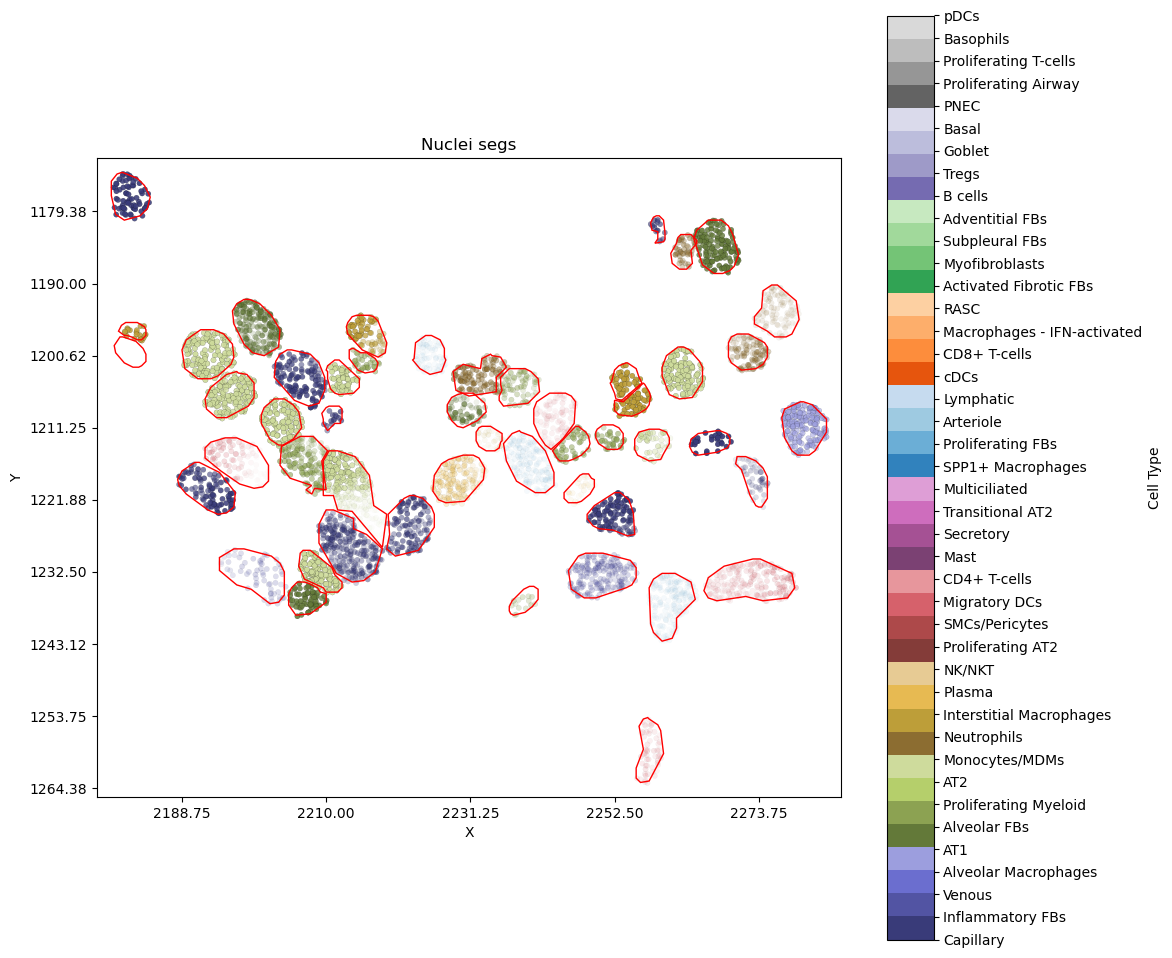

In [147]:
plot_nearby_nuc_withimage_scale_tx("VUHD116A_aaaaaopa-1",with_confi=True,alpha_by="label",show_dapi=False)

## Show DAPI as background 

The transcripts are now overlapying the DAPI image. Focusing on the cell at around [1222,2215], we can see the low confidence label probabilities for its transcripts are likely explained by the crowded nuclei thus noisy segmentation.

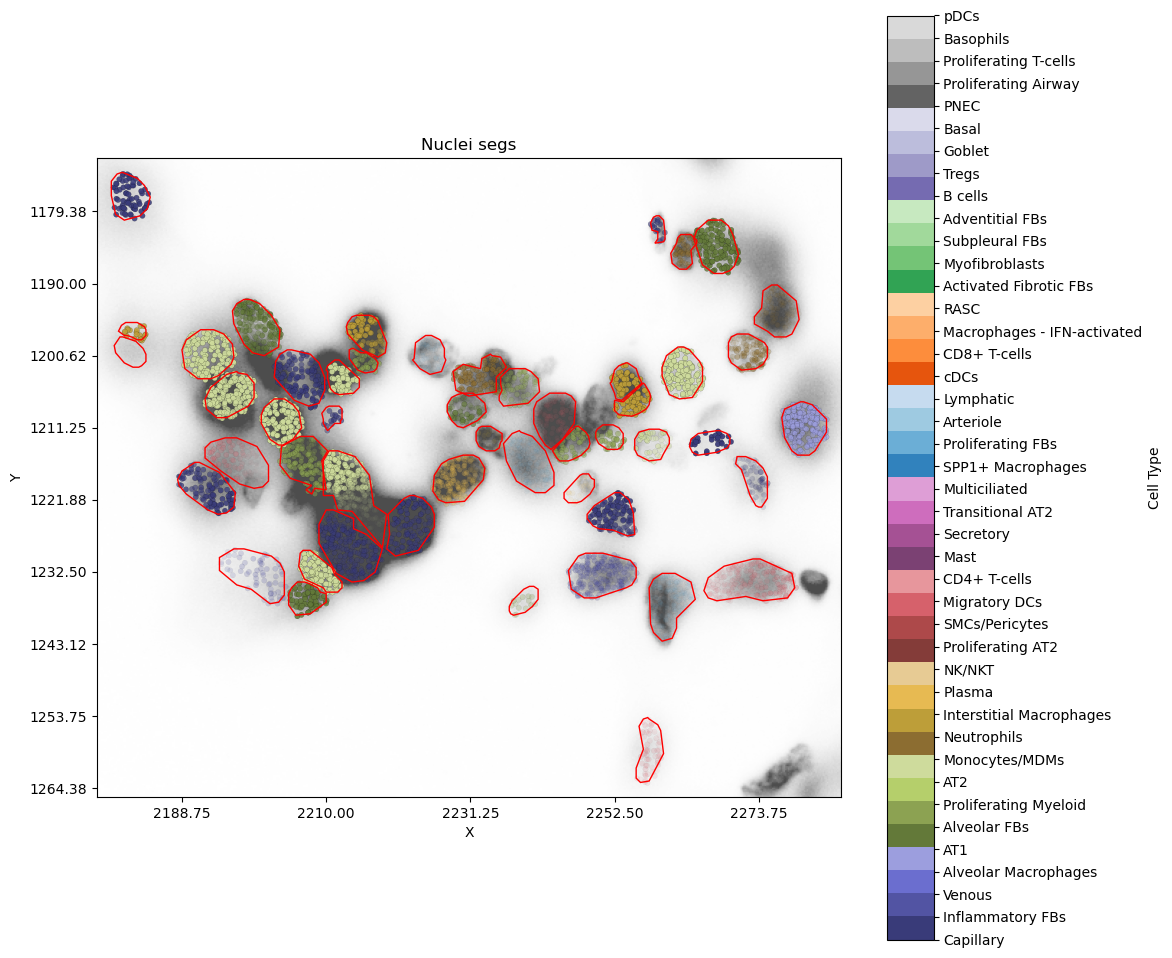

In [149]:
plot_nearby_nuc_withimage_scale_tx("VUHD116A_aaaaaopa-1",alpha_by="label",show_dapi=True)

## An interactive version

We now use plotly plots to generate the interative version of the above plots. Hovering over the transcripts will display the gene name, its (training or prediction) label along with probabilities.

In [202]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import plotly.io as pio
def plot_nearby_cells_interactive(c_id="VUHD116A_aaaaaelm-1",nearest = 50,alpha_by="label"):
    target_cell_id = c_id
    nearest_cells = find_nearest_cells(target_cell_id, centroids=cell_centroids, n=nearest)
    # subset the polys required
    df = pd.DataFrame(nuc_poly[nuc_poly.cell_id.isin(nearest_cells.cell_id)])
    
    # Create a figure
    fig = go.Figure()

   # Plot polygons (cell boundaries)
    grouped = df.groupby("cell_id")
    for name, group in grouped:
        vertices = group[['vertex_x', 'vertex_y']].values
        fig.add_trace(go.Scatter(
            x=vertices[:, 0], y=vertices[:, 1],
            fill="none", line=dict(color="black", width=0.5),
            mode="lines", 
            #name=f"Cell {name}",
            #hoverinfo="name"
        ))

    # Plot scatter points with hover info
    x_vals, y_vals, colors, labels, alphas = [], [], [], [], []
    for cell_id in nearest_cells.cell_id:
        cell_example, embs = get_cell_tx_and_embedding(cell_id)
        embs = F.softmax(torch.tensor(embs), 1).detach().numpy()

        x_vals = x_vals + list(cell_example.x_location)
        y_vals = y_vals + list(cell_example.y_location)
        if alpha_by == "prediction":
            most_likely_ct = embs.argmax(axis=1)
            most_frequent_ct = most_frequent_numpy(most_likely_ct)
            # set colors to match the above static plots
            colors = colors + ['rgb'+str(tuple(int(c * 255) for c in cmap(most_frequent_ct)[:3])) ]*len(cell_example.x_location)  # Assign color by cell type
            alphas =  alphas + list(embs[:,most_frequent_numpy(most_likely_ct)])
            paste_label = [x+"_"+y for x, y in zip(list(cell_example['feature_name']), [code_to_label[most_frequent_ct] ]*len(cell_example.x_location))]
            paste_label = [x+f"_{y:.3f}"  for x, y in zip(paste_label, list(embs[:,most_frequent_numpy(most_likely_ct)]) )]

            #paste the prob. value at the end too.
            labels = labels + paste_label
        else:
            label_ct = [cell_label_dict[x] for x in cell_example.final_CT]
           # alphas = embs[np.arange(embs.shape[0]),label_ct]

            # set colors to match the above static plots
            colors = colors + ['rgb'+str(tuple(int(c * 255) for c in cmap(label_ct[0])[:3]))]*len(cell_example.x_location)  # Assign color by cell type
            alphas =  alphas + list(embs[np.arange(embs.shape[0]),label_ct])
            paste_label = [x+"_"+y for x, y in zip(list(cell_example['feature_name']), list(cell_example['final_CT']))]
            #paste the prob. value at the end too.
            paste_label = [x+f"_{y:.3f}" for x, y in zip(paste_label,list(embs[np.arange(embs.shape[0]),label_ct]) )]
            labels = labels + paste_label
        
    ## make colors to rgba
    color_a =[]
    for cl,a in zip(colors,alphas):
        color_a = color_a +["rgba("+cl.split("(")[1].split(")")[0] + ","+str(f"{a:.4f}")+")"]
    #print(len(color_a))
    # Add points plot
    fig.add_trace(go.Scatter(
        x=x_vals, y=y_vals,
        mode="markers",
        marker=dict(size=6, color=color_a, 
                    #opacity=alphas,
                   line=dict(color='DarkSlateGrey',width=.2)),
        text=labels, hoverinfo="text"
    ))
    fig.update_layout(
        title="Interactive Nuclei Segmentation and probabiliy of transcripts' cell type labels",
        xaxis_title="X",
        yaxis_title="Y",
        yaxis=dict(scaleanchor="x",autorange="reversed"),  # Keeps aspect ratio
        template="plotly_white",
        showlegend=False
    )

    fig.show()
    return fig

### By training label

In [210]:
pio.renderers.default = "plotly_mimetype"
i_plot = plot_nearby_cells_interactive("VUHD116A_aaaaaopa-1",alpha_by="label",nearest=30)

### By prediction label

In [211]:
pio.renderers.default = "plotly_mimetype"
i_plot = plot_nearby_cells_interactive("VUHD116A_aaaaaopa-1",alpha_by="prediction",nearest=30)